<a href="https://colab.research.google.com/github/YoshifumiMiyagi/VinDr-PCXR/blob/main/VinDr_PCXR_keras_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.0 MB/s eta 0:00:00


In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [3]:
!conda install -c conda-forge gdcm -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    gdcm-2.8.9                 | py310h59700c5_10         2.7 MB  conda-forge
    json-c-0.17                |       h1220068_1          82 KB  conda-forge
    lerc-4.0.0                 |       h27087fc_0         275 KB  conda-forge
    libdeflate-1.20            |       hd590300_0          70 KB  conda-forge
    libexpat-2.6.2  

In [24]:
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import os
import cv2

from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten,Input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical

In [3]:
annotation = pd.read_csv('/content/drive/MyDrive/annotations_train.csv')
label = pd.read_csv('/content/drive/MyDrive/image_labels_train.csv')
label.head()

,image_id,rad_ID,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Situs inversus,Pneumonia,Pleuro-pneumonia,Diagphramatic hernia,Tuberculosis,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor
0,6cb53aff85c71b98ad13d67a131708c6,R3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40414c05687cdb156823c156967b13f0,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e4a464dfbf8abc6333c82f1b77b6455,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f4d3fab0b71381e6b237dc36301e85a0,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b58c9b1c89978a0b1f8533b7a2ca1088,R3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
Case = label[label['Bronchiolitis']==1]['image_id'].tolist()
Control = label[label['No finding']==1]['image_id'].tolist()

len(Case), len(Control)

(497, 5143)

# Bronchiolitis

In [5]:
img_size = (224,224)
dir_name = "/content/drive/MyDrive/train"

Bronchiolitis = []
for img in Case[0:497]:
    img_list = ('' + dir_name + '/' +img + '.dicom')
    temp_img = pydicom.dcmread(img_list)
    img_list = temp_img.pixel_array

    img_list_resized = cv2.resize(img_list, img_size)
    temp_img_array = img_to_array(img_list_resized) /255
    Bronchiolitis.append(temp_img_array)
Bronchiolitis = np.array(Bronchiolitis)
Bronchiolitis2 = Bronchiolitis.reshape(-1,50176)
df_case=pd.DataFrame(Bronchiolitis2)
df_case['label'] = np.full(Bronchiolitis.shape[0],1)

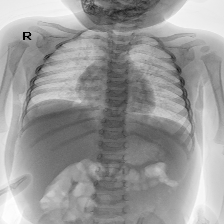

In [6]:
x = img_to_array(temp_img_array)
array_to_img(x)

# Control

In [7]:
CTRL = []
for img in Control[0:497]:
    img_list = ('' + dir_name + '/' +img + '.dicom')
    temp_img = pydicom.dcmread(img_list)
    img_list = temp_img.pixel_array

    img_list_resized = cv2.resize(img_list, img_size)
    temp_img_array = img_to_array(img_list_resized) /255
    CTRL.append(temp_img_array)
CTRL = np.array(CTRL)
CTRL2 = CTRL.reshape(-1,50176)
df_ctrl=pd.DataFrame(CTRL2)
df_ctrl['label'] = np.full(CTRL.shape[0],0)

# Preparation

In [8]:
Df = pd.concat([df_case, df_ctrl], ignore_index=True)

x_train, x_test, y_train, y_test = train_test_split(Df.iloc[:,0:-1], Df.iloc[:,-1], test_size=0.20, random_state=42)

X_train = x_train.values.reshape(-1,224,224,1)
X_test = x_test.values.reshape(-1,224,224,1)

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

# Model

In [61]:
np.random.seed(0)
model = Sequential()

model.add(BatchNormalization(input_shape=(224,224,1)))
#model.add(Input(shape=(224,224,1)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_2                │ (None, 224, 224, 1)         │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,690,662 (98.00 MB)

 Trainable params: 25,690,660 (98.00 MB)

 Non-trainable params: 2 (8.00 B)

In [63]:
model_chkpt = ModelCheckpoint('best_mod.keras', save_best_only=True, monitor='accuracy')
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=5)

In [64]:
history = model.fit(X_train, Y_train,
          validation_split=0.20,
          epochs=20, batch_size=16, shuffle=True,
          callbacks=[model_chkpt ,early_stopping]
         )

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.5477 - loss: 6.3599 - val_accuracy: 0.4906 - val_loss: 1.1332
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6072 - loss: 0.6486 - val_accuracy: 0.6164 - val_loss: 0.6988
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6594 - loss: 0.6100 - val_accuracy: 0.6101 - val_loss: 0.8129
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6964 - loss: 0.5771 - val_accuracy: 0.6101 - val_loss: 0.7844
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8107 - loss: 0.4528 - val_accuracy: 0.6352 - val_loss: 0.8182
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8710 - loss: 0.3733 - val_accuracy: 0.6101 - val_loss: 0.8033
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9003 - loss: 0.2920 - val_accuracy: 0.6038 - val_loss: 0.8516
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9146 - loss: 0.2534 - val_accuracy: 0.5849 - 

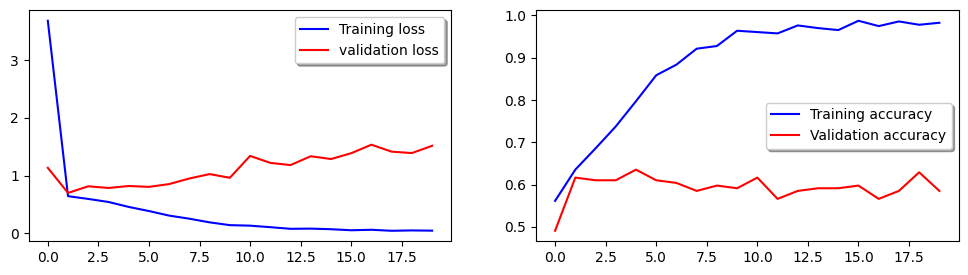

In [65]:
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

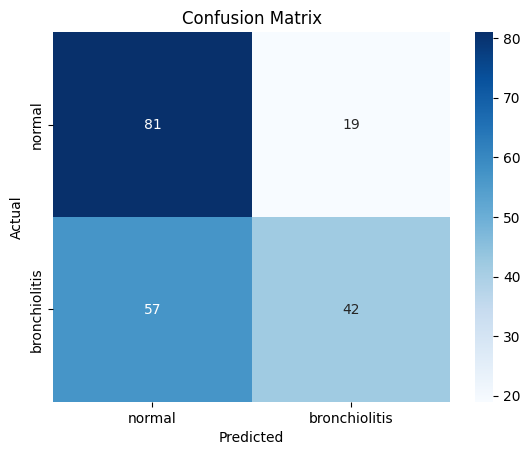

In [66]:
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
#pred = model.predict_classes(X_test)
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

Y_TEST = np.argmax(Y_test, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'bronchiolitis']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [67]:
print(classification_report(Y_TEST, pred))
print('normal = 0 , bronchiolitis = 1')

              precision    recall  f1-score   support

           0       0.59      0.81      0.68       100
           1       0.69      0.42      0.53        99

    accuracy                           0.62       199
   macro avg       0.64      0.62      0.60       199
weighted avg       0.64      0.62      0.60       199

normal = 0 , bronchiolitis = 1
